In [ ]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

torch.__version__

'2.0.1+cu118'

In [ ]:
# Allow access to google drive for working with images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Colab_Notebooks/")

In [ ]:
# Setup device-agnoistc code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [ ]:
# Setting Random Seed for Reproducibility
RANDOM_SEED = 0

# Set seed for torch
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [ ]:
# Parameter for Augmentation
AUGMENTATION = True

# File Paths

In [ ]:
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/MyDrive/Colab_Notebooks/")
image_path = data_path / "melanoma_cancer_dataset"

# Setup Train and Testing Paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# Visualize the train and test paths
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Colab_Notebooks/melanoma_cancer_dataset/train'),
 PosixPath('/content/drive/MyDrive/Colab_Notebooks/melanoma_cancer_dataset/test'))

# 1) Visualize Example Image

Random image path: /content/drive/MyDrive/Colab_Notebooks/melanoma_cancer_dataset/train/benign/melanoma_2683.jpg
Mole Class: benign
Image Height: 300
Image Width: 300


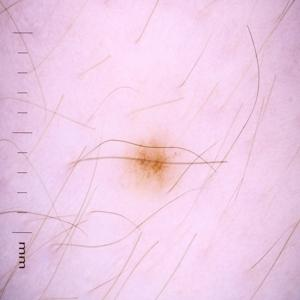

In [ ]:
import random
from PIL import Image
# Set random seed
random.seed(RANDOM_SEED)

# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get a random image
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open the image
img = Image.open(random_image_path)

# Print Information about the image and visualize
print(f"Random image path: {random_image_path}")
print(f"Mole Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

# 2) Image Transformations

In [ ]:
from torchvision import datasets, transforms

# TRAIN DATA TRANSFORMATIONS
train_transform = transforms.Compose([
    # 5% probability of random flip
    transforms.RandomHorizontalFlip(p=0.05),
    # 5% probability of random rotation
    transforms.RandomApply([transforms.RandomRotation(degrees=(-10, 10))], p=0.05),
    # 5% probability of a random colorjittter
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2,
                                                   contrast=0.2,
                                                   saturation=0.2,
                                                   hue=0.2)], p=0.05),
    # Resize the image
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # Turn Image into a torch.Tensor
    transforms.ToTensor()
    # Normalize Values for AlexNet
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
    ])

# Define Transformations for Test Data
# (No Data Augmentation)
test_transform = transforms.Compose([
    # Resize the image
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # Turn Image into a torch.Tensor
    transforms.ToTensor(),
    # Normalize Values for AlexNet
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])



# 3) Defining Training, Validation, and, Testing Data

## A) Import cutmix for data augmentation

In [ ]:
try:
  from cutmix.cutmix import CutMix
except:
  !pip install git+https://github.com/ildoonet/cutmix
  from cutmix.cutmix import CutMix

  Cloning https://github.com/ildoonet/cutmix to /tmp/pip-req-build-i5n6c17y
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/cutmix /tmp/pip-req-build-i5n6c17y
  Resolved https://github.com/ildoonet/cutmix to commit 1bc006b5f40c284a6bf4ef881906e2109a27ef6c
  Preparing metadata (setup.py) ... done
  Created wheel for cutmix: filename=cutmix-0.1-py3-none-any.whl size=3583 sha256=349b2391db36edc7a267b00e98bdd1000be2cf278b4672aad393e71a0a16d2a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-yw_sikih/wheels/ab/37/46/1a5badcd3f14d5e0b9aa97a07f976d66eb6df4e89abe015604
Successfully built cutmix


## B) Read and Transform the data

In [ ]:
from torch.utils.data import random_split

# Percentage Validation Data to Use for Training
VAL_PERC = 0.1

# Load the training data
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

# Load the testing data
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform,
                                 target_transform=None)

# Determine size of validation and training data
val_size = int(len(train_data) * VAL_PERC)
train_size = len(train_data) - val_size

# Split the Validation Data from the training data
train_data, val_data = random_split(train_data, [train_size, val_size])

In [ ]:
# Check the length of the training and testing dataset
print(f"Length of Train: {len(train_data)}")
print(f"Length of Validation: {len(val_data)}")
print(f"Length of Test: {len(test_data)}")
print()
print(f"Dimensions of Tensorflow Image: {test_data[0][0].shape}")

Length of Train: 7745
Length of Validation: 860
Length of Test: 2000

Dimensions of Tensorflow Image: torch.Size([3, 224, 224])


# 4) Load data into data loader

In [ ]:
import os
# Define Batch Size and Num_workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [ ]:
# Turn the train and test datasets into dataloaders
from torch.utils.data import DataLoader

print(f"Creating DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              drop_last=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True,
                            drop_last=True)

train_dataloader, test_dataloader, val_dataloader

Creating DataLoaders with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x79d8e0cf1ea0>,
 <torch.utils.data.dataloader.DataLoader at 0x79d8e0cf0dc0>)

# 5) Building Models

# 6) Training the Models

In [ ]:
# try:
#   from alexnet_pytorch import AlexNet
# except:
#   !pip install alexnet_pytorch
#   from alexnet_pytorch import AlexNet

In [ ]:
import torchvision.models as models

In [ ]:
from training_script import train as Train


NUM_EPOCHS = 10
LEARN_RATE = 0.0001

# Create an instance of the Alexnet model
model_0 = models.alexnet(pretrained=False).to(device)
model_0.classifier[6] = torch.nn.Linear(4096, 1).to(device)
# model_0 = AlexNet.from_pretrained('alexnet', num_classes=1).to(device)

# Setup the loss function and the optimizer
# Binary Cross Entropy Loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARN_RATE)

# Train the model
model_0_results, model_0_state_dict = Train(model=model_0,
                                            train_dataloader=train_dataloader,
                                            val_dataloader=val_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=NUM_EPOCHS,
                                            device=device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 || Train Loss: 0.51089 || Train Accuracy: 0.74212 || Validation Loss: 0.67701 || Validation Accuracy: 0.58053
Epoch: 2 || Train Loss: 0.38031 || Train Accuracy: 0.83497 || Validation Loss: 0.36238 || Validation Accuracy: 0.87620
Epoch: 3 || Train Loss: 0.34269 || Train Accuracy: 0.85369 || Validation Loss: 0.27950 || Validation Accuracy: 0.87861
Epoch: 4 || Train Loss: 0.32779 || Train Accuracy: 0.85938 || Validation Loss: 0.30737 || Validation Accuracy: 0.86298
Epoch: 5 || Train Loss: 0.28826 || Train Accuracy: 0.87707 || Validation Loss: 0.24474 || Validation Accuracy: 0.89663
Epoch: 6 || Train Loss: 0.29549 || Train Accuracy: 0.87487 || Validation Loss: 0.24617 || Validation Accuracy: 0.88822
Epoch: 7 || Train Loss: 0.25966 || Train Accuracy: 0.89127 || Validation Loss: 0.23617 || Validation Accuracy: 0.89543
Epoch: 8 || Train Loss: 0.26051 || Train Accuracy: 0.89334 || Validation Loss: 0.25343 || Validation Accuracy: 0.89062
Epoch: 9 || Train Loss: 0.24589 || Train Accurac

# 7) Save Trained Model Parameters

In [ ]:
# Model Name
MODEL_NAME = f"AlexNet_{NUM_EPOCHS}_iter_Aug_{AUGMENTATION}"

# The directory to store the model
models_dir = "/content/drive/MyDrive/Colab_Notebooks/models/"
file_path = models_dir + MODEL_NAME + ".pth"

# Save the model
torch.save(model_0_state_dict, file_path)